# Create a Deep Learning VM on Google Cloud Platform

This project is deployed on Google Cloud Platform in order to take advantage of GPU-accelerated training of the Generator and Discriminator networks.


Using: 1x NVIDIA Tesla P100 GPU


Following these instructions:
https://github.com/sdrangan/introml/blob/master/GCP/getting_started.md

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import numpy as np

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

Random Seed:  999


In [2]:
# img = Image.open('/Users/alexandergao/Documents/DeepLearning/Competition/experiments/gan/git/ML-Project-Generative-Adversarial-Network/data/road_images/img/scene_106_sample_0_road_map.png')
# img = np.array(img)
# img.shape

In [3]:
# Root directory for dataset
dataroot = "data/road_images"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 240

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

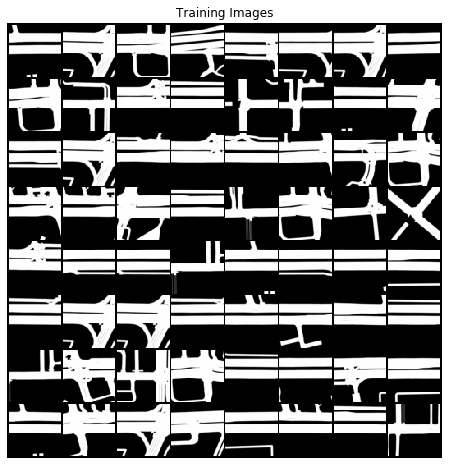

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.Grayscale(num_output_channels=1),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))

# print(real_batch[0].data.numpy().shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Maximization / Minimization Problem for GANs

A neural network G(z, θ₁) is used to model the Generator mentioned above. It’s role is mapping input noise variables z to the desired data space x (say images). Conversely, a second neural network D(x, θ₂) models the discriminator and outputs the probability that the data came from the real dataset, in the range (0,1). In both cases, θᵢ represents the weights or parameters that define each neural network.

As a result, the Discriminator is trained to correctly classify the input data as either real or fake. This means it’s weights are updated as to maximize the probability that any real data input x is classified as belonging to the real dataset, while minimizing the probability that any fake image is classified as belonging to the real dataset. In more technical terms, the loss/error function used maximizes the function D(x), and it also minimizes D(G(z)).

Furthermore, the Generator is trained to fool the Discriminator by generating data as realistic as possible, which means that the Generator’s weight’s are optimized to maximize the probability that any fake image is classified as belonging to the real datase. Formally this means that the loss/error function used for this network maximizes D(G(z)).

Source: https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f



[My words] To summarize, the "adversarial" optimization goals are:

- DISCRIMINATOR: Train the Discriminator such that D(x) is maximized, where x is a sample from the original training dataset, and to minimize D(G(z)), which is the probability of a generated sample being classified as authentic.
- GENERATOR: train the Generator such that D(G(z)), the probability P that a generated sample will be classified as an authentic sample, is maximized.

# Loss Function

The networks use Binary-Crossentropy loss function, mathematically described as:

<img src = "files/gan_loss_function.png">

# Modified code based on the following tutorial on PyTorch:

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

## Additional Sources
https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f

In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Define Generator Class and Create Generator Object

In [6]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [7]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Define Discriminator Class and Create Generator Object

In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [9]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Define Loss Function, Set Label Values, and Create Optimizers

In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [11]:
print(len(dataloader))

28


# Main Training Loop

In [12]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        print("Epoch #:", epoch, "\tBatch #:", i, " / 28")
#         print("len of data[0]: ",len(data[0]))
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
#         print("len of label: ",len(label))
#         print("len of real_cpu: ",len(real_cpu))
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
#         print("len of output: ",len(output))
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
Epoch #: 0 	Batch #: 0  / 28
[0/240][0/28]	Loss_D: 1.4941	Loss_G: 3.3748	D(x): 0.4590	D(G(z)): 0.3872 / 0.0497
Epoch #: 0 	Batch #: 1  / 28
Epoch #: 0 	Batch #: 2  / 28
Epoch #: 0 	Batch #: 3  / 28
Epoch #: 0 	Batch #: 4  / 28
Epoch #: 0 	Batch #: 5  / 28
Epoch #: 0 	Batch #: 6  / 28
Epoch #: 0 	Batch #: 7  / 28
Epoch #: 0 	Batch #: 8  / 28
Epoch #: 0 	Batch #: 9  / 28
Epoch #: 0 	Batch #: 10  / 28
Epoch #: 0 	Batch #: 11  / 28
Epoch #: 0 	Batch #: 12  / 28
Epoch #: 0 	Batch #: 13  / 28
Epoch #: 0 	Batch #: 14  / 28
Epoch #: 0 	Batch #: 15  / 28
Epoch #: 0 	Batch #: 16  / 28
Epoch #: 0 	Batch #: 17  / 28
Epoch #: 0 	Batch #: 18  / 28
Epoch #: 0 	Batch #: 19  / 28
Epoch #: 0 	Batch #: 20  / 28
Epoch #: 0 	Batch #: 21  / 28
Epoch #: 0 	Batch #: 22  / 28
Epoch #: 0 	Batch #: 23  / 28
Epoch #: 0 	Batch #: 24  / 28
Epoch #: 0 	Batch #: 25  / 28
Epoch #: 0 	Batch #: 26  / 28
Epoch #: 0 	Batch #: 27  / 28
Epoch #: 1 	Batch #: 0  / 28
[1/240][0/28]	Loss_D: 0.0356	Loss

Epoch #: 8 	Batch #: 27  / 28
Epoch #: 9 	Batch #: 0  / 28
[9/240][0/28]	Loss_D: 0.0101	Loss_G: 7.0858	D(x): 0.9948	D(G(z)): 0.0049 / 0.0009
Epoch #: 9 	Batch #: 1  / 28
Epoch #: 9 	Batch #: 2  / 28
Epoch #: 9 	Batch #: 3  / 28
Epoch #: 9 	Batch #: 4  / 28
Epoch #: 9 	Batch #: 5  / 28
Epoch #: 9 	Batch #: 6  / 28
Epoch #: 9 	Batch #: 7  / 28
Epoch #: 9 	Batch #: 8  / 28
Epoch #: 9 	Batch #: 9  / 28
Epoch #: 9 	Batch #: 10  / 28
Epoch #: 9 	Batch #: 11  / 28
Epoch #: 9 	Batch #: 12  / 28
Epoch #: 9 	Batch #: 13  / 28
Epoch #: 9 	Batch #: 14  / 28
Epoch #: 9 	Batch #: 15  / 28
Epoch #: 9 	Batch #: 16  / 28
Epoch #: 9 	Batch #: 17  / 28
Epoch #: 9 	Batch #: 18  / 28
Epoch #: 9 	Batch #: 19  / 28
Epoch #: 9 	Batch #: 20  / 28
Epoch #: 9 	Batch #: 21  / 28
Epoch #: 9 	Batch #: 22  / 28
Epoch #: 9 	Batch #: 23  / 28
Epoch #: 9 	Batch #: 24  / 28
Epoch #: 9 	Batch #: 25  / 28
Epoch #: 9 	Batch #: 26  / 28
Epoch #: 9 	Batch #: 27  / 28
Epoch #: 10 	Batch #: 0  / 28
[10/240][0/28]	Loss_D: 0.015

Epoch #: 17 	Batch #: 20  / 28
Epoch #: 17 	Batch #: 21  / 28
Epoch #: 17 	Batch #: 22  / 28
Epoch #: 17 	Batch #: 23  / 28
Epoch #: 17 	Batch #: 24  / 28
Epoch #: 17 	Batch #: 25  / 28
Epoch #: 17 	Batch #: 26  / 28
Epoch #: 17 	Batch #: 27  / 28
Epoch #: 18 	Batch #: 0  / 28
[18/240][0/28]	Loss_D: 0.1310	Loss_G: 4.4791	D(x): 0.9418	D(G(z)): 0.0645 / 0.0117
Epoch #: 18 	Batch #: 1  / 28
Epoch #: 18 	Batch #: 2  / 28
Epoch #: 18 	Batch #: 3  / 28
Epoch #: 18 	Batch #: 4  / 28
Epoch #: 18 	Batch #: 5  / 28
Epoch #: 18 	Batch #: 6  / 28
Epoch #: 18 	Batch #: 7  / 28
Epoch #: 18 	Batch #: 8  / 28
Epoch #: 18 	Batch #: 9  / 28
Epoch #: 18 	Batch #: 10  / 28
Epoch #: 18 	Batch #: 11  / 28
Epoch #: 18 	Batch #: 12  / 28
Epoch #: 18 	Batch #: 13  / 28
Epoch #: 18 	Batch #: 14  / 28
Epoch #: 18 	Batch #: 15  / 28
Epoch #: 18 	Batch #: 16  / 28
Epoch #: 18 	Batch #: 17  / 28
Epoch #: 18 	Batch #: 18  / 28
Epoch #: 18 	Batch #: 19  / 28
Epoch #: 18 	Batch #: 20  / 28
Epoch #: 18 	Batch #: 21  / 

Epoch #: 26 	Batch #: 12  / 28
Epoch #: 26 	Batch #: 13  / 28
Epoch #: 26 	Batch #: 14  / 28
Epoch #: 26 	Batch #: 15  / 28
Epoch #: 26 	Batch #: 16  / 28
Epoch #: 26 	Batch #: 17  / 28
Epoch #: 26 	Batch #: 18  / 28
Epoch #: 26 	Batch #: 19  / 28
Epoch #: 26 	Batch #: 20  / 28
Epoch #: 26 	Batch #: 21  / 28
Epoch #: 26 	Batch #: 22  / 28
Epoch #: 26 	Batch #: 23  / 28
Epoch #: 26 	Batch #: 24  / 28
Epoch #: 26 	Batch #: 25  / 28
Epoch #: 26 	Batch #: 26  / 28
Epoch #: 26 	Batch #: 27  / 28
Epoch #: 27 	Batch #: 0  / 28
[27/240][0/28]	Loss_D: 0.0299	Loss_G: 7.3551	D(x): 0.9886	D(G(z)): 0.0178 / 0.0009
Epoch #: 27 	Batch #: 1  / 28
Epoch #: 27 	Batch #: 2  / 28
Epoch #: 27 	Batch #: 3  / 28
Epoch #: 27 	Batch #: 4  / 28
Epoch #: 27 	Batch #: 5  / 28
Epoch #: 27 	Batch #: 6  / 28
Epoch #: 27 	Batch #: 7  / 28
Epoch #: 27 	Batch #: 8  / 28
Epoch #: 27 	Batch #: 9  / 28
Epoch #: 27 	Batch #: 10  / 28
Epoch #: 27 	Batch #: 11  / 28
Epoch #: 27 	Batch #: 12  / 28
Epoch #: 27 	Batch #: 13  / 

Epoch #: 35 	Batch #: 3  / 28
Epoch #: 35 	Batch #: 4  / 28
Epoch #: 35 	Batch #: 5  / 28
Epoch #: 35 	Batch #: 6  / 28
Epoch #: 35 	Batch #: 7  / 28
Epoch #: 35 	Batch #: 8  / 28
Epoch #: 35 	Batch #: 9  / 28
Epoch #: 35 	Batch #: 10  / 28
Epoch #: 35 	Batch #: 11  / 28
Epoch #: 35 	Batch #: 12  / 28
Epoch #: 35 	Batch #: 13  / 28
Epoch #: 35 	Batch #: 14  / 28
Epoch #: 35 	Batch #: 15  / 28
Epoch #: 35 	Batch #: 16  / 28
Epoch #: 35 	Batch #: 17  / 28
Epoch #: 35 	Batch #: 18  / 28
Epoch #: 35 	Batch #: 19  / 28
Epoch #: 35 	Batch #: 20  / 28
Epoch #: 35 	Batch #: 21  / 28
Epoch #: 35 	Batch #: 22  / 28
Epoch #: 35 	Batch #: 23  / 28
Epoch #: 35 	Batch #: 24  / 28
Epoch #: 35 	Batch #: 25  / 28
Epoch #: 35 	Batch #: 26  / 28
Epoch #: 35 	Batch #: 27  / 28
Epoch #: 36 	Batch #: 0  / 28
[36/240][0/28]	Loss_D: 0.0002	Loss_G: 48.5773	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
Epoch #: 36 	Batch #: 1  / 28
Epoch #: 36 	Batch #: 2  / 28
Epoch #: 36 	Batch #: 3  / 28
Epoch #: 36 	Batch #: 4  / 2

Epoch #: 43 	Batch #: 25  / 28
Epoch #: 43 	Batch #: 26  / 28
Epoch #: 43 	Batch #: 27  / 28
Epoch #: 44 	Batch #: 0  / 28
[44/240][0/28]	Loss_D: 0.0000	Loss_G: 48.6719	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
Epoch #: 44 	Batch #: 1  / 28
Epoch #: 44 	Batch #: 2  / 28
Epoch #: 44 	Batch #: 3  / 28
Epoch #: 44 	Batch #: 4  / 28
Epoch #: 44 	Batch #: 5  / 28
Epoch #: 44 	Batch #: 6  / 28
Epoch #: 44 	Batch #: 7  / 28
Epoch #: 44 	Batch #: 8  / 28
Epoch #: 44 	Batch #: 9  / 28
Epoch #: 44 	Batch #: 10  / 28
Epoch #: 44 	Batch #: 11  / 28
Epoch #: 44 	Batch #: 12  / 28
Epoch #: 44 	Batch #: 13  / 28
Epoch #: 44 	Batch #: 14  / 28
Epoch #: 44 	Batch #: 15  / 28
Epoch #: 44 	Batch #: 16  / 28
Epoch #: 44 	Batch #: 17  / 28
Epoch #: 44 	Batch #: 18  / 28
Epoch #: 44 	Batch #: 19  / 28
Epoch #: 44 	Batch #: 20  / 28
Epoch #: 44 	Batch #: 21  / 28
Epoch #: 44 	Batch #: 22  / 28
Epoch #: 44 	Batch #: 23  / 28
Epoch #: 44 	Batch #: 24  / 28
Epoch #: 44 	Batch #: 25  / 28
Epoch #: 44 	Batch #: 26  /

Epoch #: 52 	Batch #: 16  / 28
Epoch #: 52 	Batch #: 17  / 28
Epoch #: 52 	Batch #: 18  / 28
Epoch #: 52 	Batch #: 19  / 28
Epoch #: 52 	Batch #: 20  / 28
Epoch #: 52 	Batch #: 21  / 28
Epoch #: 52 	Batch #: 22  / 28
Epoch #: 52 	Batch #: 23  / 28
Epoch #: 52 	Batch #: 24  / 28
Epoch #: 52 	Batch #: 25  / 28
Epoch #: 52 	Batch #: 26  / 28
Epoch #: 52 	Batch #: 27  / 28
Epoch #: 53 	Batch #: 0  / 28
[53/240][0/28]	Loss_D: 0.0000	Loss_G: 48.5455	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
Epoch #: 53 	Batch #: 1  / 28
Epoch #: 53 	Batch #: 2  / 28
Epoch #: 53 	Batch #: 3  / 28
Epoch #: 53 	Batch #: 4  / 28
Epoch #: 53 	Batch #: 5  / 28
Epoch #: 53 	Batch #: 6  / 28
Epoch #: 53 	Batch #: 7  / 28
Epoch #: 53 	Batch #: 8  / 28
Epoch #: 53 	Batch #: 9  / 28
Epoch #: 53 	Batch #: 10  / 28
Epoch #: 53 	Batch #: 11  / 28
Epoch #: 53 	Batch #: 12  / 28
Epoch #: 53 	Batch #: 13  / 28
Epoch #: 53 	Batch #: 14  / 28
Epoch #: 53 	Batch #: 15  / 28
Epoch #: 53 	Batch #: 16  / 28
Epoch #: 53 	Batch #: 17  /

RuntimeError: DataLoader worker (pid(s) 9652) exited unexpectedly

# Visualizing Loss

We plot Loss for the Generator and Discriminator networks over # of cumulative training iterations.

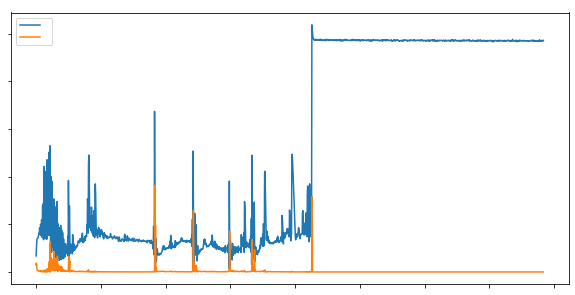

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

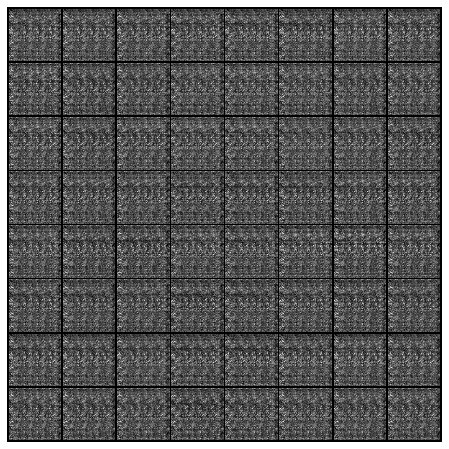

In [16]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000/12, repeat_delay=1000/12, blit=True)

HTML(ani.to_jshtml())

In [17]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

RuntimeError: DataLoader worker (pid(s) 46070, 46071) exited unexpectedly